In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "DBB"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [7]:
USE_FULL_DF = True

if USE_FULL_DF:
    dataset = pd.read_csv(df_path)
else:
    dataset_ = pd.read_csv(df_path)
    r = min(5000/len(dataset_), 1)
    _, dataset = train_test_split(dataset_, test_size=r, stratify=dataset_['class'], random_state=42)
dataset.head()

,id,sequence,length,class
0,Achn006881,MSTREDMWTLYISRRVSNKERETRENNRSGRERERMKIQCDVCAKE...,257,1
1,Achn039341,MDKNCKSTASAISACDFCNQKSAVLYCKADSAKLCLFCDQQVHSAN...,411,1
2,Achn067171,MRTLCDVCESAAAILFCAADEAALCRSCDDKVHMCNKLASRHVRVG...,217,1
3,Achn084001,MKIQCDVCEKAPASVICCADEAALCAKCDIEVHAANKLASKHQRLL...,241,1
4,Achn101441,MFKKNSIKTRYFNLRKCIRFRTSGGGCYESNSETLPDVVGGFCLVE...,365,1


In [8]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [9]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".keras", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=False
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [10]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
2926,0.006135,0.000000,0.006135,0.010225,0.004090,0.002045,0.0,0.002045,0.004090,0.004090,...,0.002045,0.000000,0.002045,0.0,0.000000,0.002045,0.0,0.002045,0.0,0.000000
913,0.010067,0.003356,0.003356,0.000000,0.000000,0.000000,0.0,0.006711,0.000000,0.006711,...,0.000000,0.000000,0.000000,0.0,0.003356,0.000000,0.0,0.000000,0.0,0.000000
2975,0.002778,0.000000,0.002778,0.002778,0.002778,0.000000,0.0,0.002778,0.002778,0.000000,...,0.000000,0.005556,0.005556,0.0,0.002778,0.000000,0.0,0.000000,0.0,0.002778
2794,0.008299,0.000000,0.004149,0.000000,0.000000,0.016598,0.0,0.000000,0.000000,0.004149,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000
2472,0.000000,0.000000,0.000000,0.008065,0.004032,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.004032,0.000000,0.0,0.004032,0.000000,0.0,0.000000,0.0,0.004032


In [11]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (2620, 441)
X_test: (656, 441)
y_train: (2620,)
y_test: (656,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [12]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         113,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,417 (611.00 KB)

 Trainable params: 156,417 (611.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 14s 466ms/step - accuracy: 0.5781 - loss: 0.6932

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7928 - loss: 0.6668   

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7958 - loss: 0.6651 - val_accuracy: 0.9790 - val_loss: 0.3361


Epoch 2/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.3697

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9777 - loss: 0.2131 - val_accuracy: 0.9885 - val_loss: 0.0361


Epoch 3/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.0252

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9764 - loss: 0.0609 - val_accuracy: 0.9866 - val_loss: 0.0460


Epoch 4/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.0277

30/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9880 - loss: 0.0405

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9882 - loss: 0.0398 - val_accuracy: 0.9905 - val_loss: 0.0296


Epoch 5/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0073

29/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9896 - loss: 0.0375

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9898 - loss: 0.0366 - val_accuracy: 0.9885 - val_loss: 0.0332


Epoch 6/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.0179

31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9904 - loss: 0.0284

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9905 - loss: 0.0283 - val_accuracy: 0.9924 - val_loss: 0.0262


Epoch 7/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0045

30/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9972 - loss: 0.0115

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9971 - loss: 0.0117 - val_accuracy: 0.9924 - val_loss: 0.0250


Epoch 8/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.0647

30/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9955 - loss: 0.0204

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9953 - loss: 0.0205 - val_accuracy: 0.9905 - val_loss: 0.0507


Epoch 9/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.0329

30/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9922 - loss: 0.0252

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9922 - loss: 0.0255 - val_accuracy: 0.9924 - val_loss: 0.0218


Epoch 10/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9688 - loss: 0.0294

30/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9929 - loss: 0.0189

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9932 - loss: 0.0189 - val_accuracy: 0.9943 - val_loss: 0.0291


Epoch 11/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0040

30/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 0.0052

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9994 - loss: 0.0061 - val_accuracy: 0.9962 - val_loss: 0.0184


Epoch 12/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0035

31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9967 - loss: 0.0107

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9966 - loss: 0.0108 - val_accuracy: 0.9866 - val_loss: 0.0294


Epoch 13/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0061

31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9979 - loss: 0.0055

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9978 - loss: 0.0056 - val_accuracy: 0.9905 - val_loss: 0.0246


Epoch 14/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0017

30/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9974 - loss: 0.0064

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9975 - loss: 0.0064 - val_accuracy: 0.9943 - val_loss: 0.0211


Epoch 15/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 8.1132e-04

31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9980 - loss: 0.0084    

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9980 - loss: 0.0083 - val_accuracy: 0.9943 - val_loss: 0.0219


Epoch 16/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0011

30/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9997 - loss: 0.0021

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 0.0024 - val_accuracy: 0.9943 - val_loss: 0.0223


Epoch 17/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.8724e-04

31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9995 - loss: 0.0023    

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9995 - loss: 0.0024 - val_accuracy: 0.9943 - val_loss: 0.0211


Epoch 18/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 6.4217e-04

31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0012    

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.9943 - val_loss: 0.0235


Epoch 19/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0045

32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0015

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 0.9943 - val_loss: 0.0246


Epoch 20/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0017

29/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 9.1251e-04

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 9.3032e-04 - val_accuracy: 0.9943 - val_loss: 0.0228


Epoch 21/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.5319e-04

30/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9989 - loss: 0.0019    

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9989 - loss: 0.0019 - val_accuracy: 0.9962 - val_loss: 0.0228



[Train Accuracy: 99.90% - Test Accuracy: 98.93%]


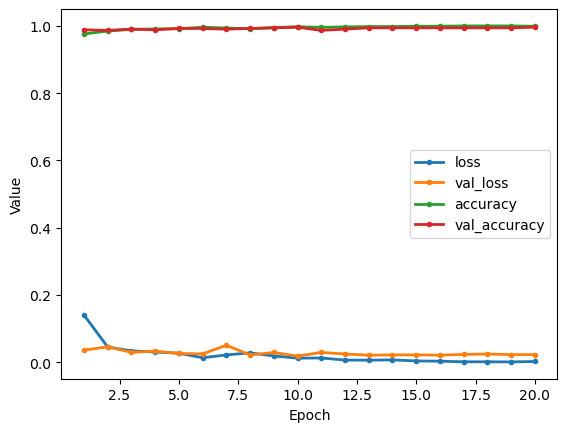

In [13]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [14]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k2, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 1/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [15]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYW,YYX,YYY
2926,0.0,0.0,0.002049,0.0,0.0,0.002049,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
913,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.003367,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2975,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2794,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2472,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.004049,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (2620, 8585)
X_test: (656, 8585)
y_train: (2620,)
y_test: (656,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [17]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,198,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,241,281 (8.55 MB)

 Trainable params: 2,241,281 (8.55 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 15s 474ms/step - accuracy: 0.5156 - loss: 0.6932

 9/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5372 - loss: 0.6923   

18/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5762 - loss: 0.6885

27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6192 - loss: 0.6801

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6476 - loss: 0.6696 - val_accuracy: 0.9370 - val_loss: 0.3910


Epoch 2/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9062 - loss: 0.4087

10/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9449 - loss: 0.3554 

19/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9557 - loss: 0.3105

28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9630 - loss: 0.2724

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9660 - loss: 0.2518 - val_accuracy: 0.9924 - val_loss: 0.0242


Epoch 3/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0217

10/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9988 - loss: 0.0156 

19/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9980 - loss: 0.0163

28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9979 - loss: 0.0156

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9980 - loss: 0.0154 - val_accuracy: 0.9924 - val_loss: 0.0211


Epoch 4/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0029

10/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0030 

19/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9998 - loss: 0.0041

28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9996 - loss: 0.0054

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9995 - loss: 0.0061 - val_accuracy: 0.9943 - val_loss: 0.0317


Epoch 5/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 8.5039e-04

10/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0011     

19/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9998 - loss: 0.0019

28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9996 - loss: 0.0024

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9996 - loss: 0.0025 - val_accuracy: 0.9943 - val_loss: 0.0310


Epoch 6/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 7.4229e-04

10/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0017     

19/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0016

28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0016

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 0.9924 - val_loss: 0.0197


Epoch 7/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0017

10/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0013 

19/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0012

28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0011

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9943 - val_loss: 0.0243


Epoch 8/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 7.3668e-04

10/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9997 - loss: 0.0023     

19/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9993 - loss: 0.0025

28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9993 - loss: 0.0023

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9994 - loss: 0.0022 - val_accuracy: 0.9924 - val_loss: 0.0490


Epoch 9/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0040

10/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0013 

19/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.6261e-04

28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.0310e-04

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.3688e-04 - val_accuracy: 0.9943 - val_loss: 0.0270


Epoch 10/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 1.4153e-04

10/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.5020e-04 

19/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.9094e-04

28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.4711e-04

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.2890e-04 - val_accuracy: 0.9943 - val_loss: 0.0297


Epoch 11/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 2.6662e-04

10/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.0995e-04 

19/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.1339e-04

28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.0402e-04

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.9673e-04 - val_accuracy: 0.9943 - val_loss: 0.0292


Epoch 12/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 6.9005e-05

10/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.9262e-04 

19/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.1998e-04

28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.4555e-04

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.4157e-04 - val_accuracy: 0.9943 - val_loss: 0.0267


Epoch 13/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 1.5348e-04

10/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.3076e-04 

19/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1554e-04

28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.3491e-04

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4023e-04 - val_accuracy: 0.9924 - val_loss: 0.0246


Epoch 14/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 1.0059e-04

10/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.9009e-05 

19/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.5046e-05

28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.6438e-05

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0744e-04 - val_accuracy: 0.9943 - val_loss: 0.0363



[Train Accuracy: 100.00% - Test Accuracy: 99.39%]


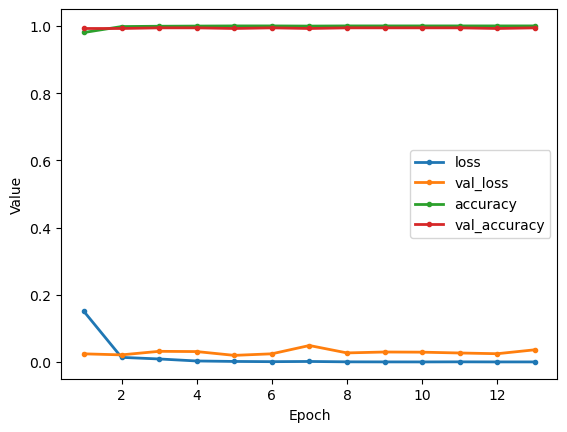

In [18]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [19]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k3, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 1/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [20]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYYM,YYYN,YYYP,YYYQ,YYYR,YYYS,YYYT,YYYV,YYYX,YYYY
2926,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
913,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2975,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2794,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2472,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [22]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      33,022,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,063,937 (126.13 MB)

 Trainable params: 33,063,937 (126.13 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 20s 651ms/step - accuracy: 0.4688 - loss: 0.6932

 2/33 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.4844 - loss: 0.6931  

 3/33 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.4913 - loss: 0.6930

 4/33 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.4906 - loss: 0.6930

 5/33 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.4993 - loss: 0.6929

 6/33 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.5107 - loss: 0.6928

 7/33 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.5239 - loss: 0.6926

 8/33 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.5365 - loss: 0.6925

 9/33 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.5498 - loss: 0.6923

10/33 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.5630 - loss: 0.6922

11/33 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.5750 - loss: 0.6920

12/33 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.5866 - loss: 0.6918

13/33 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.5980 - loss: 0.6915

14/33 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.6088 - loss: 0.6913

15/33 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.6193 - loss: 0.6910

16/33 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.6290 - loss: 0.6907

17/33 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.6379 - loss: 0.6903

18/33 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.6461 - loss: 0.6900

19/33 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.6539 - loss: 0.6896

20/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.6613 - loss: 0.6891

21/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.6684 - loss: 0.6887

22/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.6752 - loss: 0.6881

23/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.6816 - loss: 0.6876

24/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.6877 - loss: 0.6870

25/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.6936 - loss: 0.6864

26/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.6992 - loss: 0.6857

27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.7045 - loss: 0.6850

28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.7095 - loss: 0.6842

29/33 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.7143 - loss: 0.6834

30/33 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.7189 - loss: 0.6825

31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.7234 - loss: 0.6816

32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.7276 - loss: 0.6806

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.7317 - loss: 0.6796

33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.7356 - loss: 0.6786 - val_accuracy: 0.9656 - val_loss: 0.4920


Epoch 2/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.9688 - loss: 0.4854

 2/33 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.9688 - loss: 0.4800

 3/33 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.9688 - loss: 0.4765

 4/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9697 - loss: 0.4721

 5/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9714 - loss: 0.4674

 6/33 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.9727 - loss: 0.4626

 7/33 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.9740 - loss: 0.4572

 8/33 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.9751 - loss: 0.4515

 9/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9757 - loss: 0.4460

10/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9760 - loss: 0.4407

11/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9761 - loss: 0.4353

12/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9762 - loss: 0.4299

13/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9764 - loss: 0.4245

14/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9767 - loss: 0.4191

15/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9768 - loss: 0.4137

16/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9769 - loss: 0.4084

17/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9770 - loss: 0.4031

18/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9773 - loss: 0.3978

19/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9774 - loss: 0.3927

20/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9775 - loss: 0.3876

21/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9777 - loss: 0.3826

22/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9778 - loss: 0.3776

23/33 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9780 - loss: 0.3728

24/33 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9781 - loss: 0.3679

25/33 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9783 - loss: 0.3632

26/33 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9785 - loss: 0.3585

27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9787 - loss: 0.3540

28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9788 - loss: 0.3495

29/33 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9789 - loss: 0.3452

30/33 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9790 - loss: 0.3410

31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9792 - loss: 0.3368

32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9792 - loss: 0.3328

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9793 - loss: 0.3289

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.9794 - loss: 0.3252 - val_accuracy: 0.9847 - val_loss: 0.0511


Epoch 3/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 0.0251

 2/33 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 1.0000 - loss: 0.0231 

 3/33 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 1.0000 - loss: 0.0219

 4/33 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 0.0210

 5/33 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 0.0202

 6/33 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 0.0196

 7/33 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.9997 - loss: 0.0194

 8/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9992 - loss: 0.0197

 9/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9989 - loss: 0.0199

10/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9987 - loss: 0.0199

11/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9986 - loss: 0.0198

12/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9985 - loss: 0.0196

13/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9984 - loss: 0.0193

14/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9984 - loss: 0.0190

15/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9983 - loss: 0.0188

16/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9983 - loss: 0.0185

17/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9983 - loss: 0.0183

18/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9983 - loss: 0.0180

19/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9983 - loss: 0.0178

20/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9983 - loss: 0.0175

21/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9983 - loss: 0.0173

22/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9983 - loss: 0.0171

23/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9984 - loss: 0.0169

24/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9984 - loss: 0.0167

25/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9984 - loss: 0.0165

26/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9984 - loss: 0.0163

27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9984 - loss: 0.0162

28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9984 - loss: 0.0160

29/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9984 - loss: 0.0159

30/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9984 - loss: 0.0158

31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9984 - loss: 0.0156

32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9984 - loss: 0.0155

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9984 - loss: 0.0154

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.9984 - loss: 0.0153 - val_accuracy: 0.9885 - val_loss: 0.0359


Epoch 4/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - accuracy: 1.0000 - loss: 0.0028

 2/33 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 1.0000 - loss: 0.0030

 3/33 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 1.0000 - loss: 0.0032

 4/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 0.0032

 5/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 0.0033

 6/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 0.0032

 7/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 0.0031

 8/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 0.0031

 9/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 0.0030

10/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 0.0030

11/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 0.0029

12/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 0.0029

13/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 0.0028

14/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9999 - loss: 0.0029

15/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9999 - loss: 0.0029

16/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9998 - loss: 0.0030

17/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9998 - loss: 0.0030

18/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9997 - loss: 0.0030

19/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9997 - loss: 0.0030

20/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9997 - loss: 0.0030

21/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9997 - loss: 0.0030

22/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9996 - loss: 0.0030

23/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9996 - loss: 0.0031

24/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9996 - loss: 0.0031

25/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9996 - loss: 0.0031

26/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9996 - loss: 0.0031

27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9996 - loss: 0.0031

28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9996 - loss: 0.0031

29/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9996 - loss: 0.0031

30/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9996 - loss: 0.0031

31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9996 - loss: 0.0031

32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9996 - loss: 0.0030

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9996 - loss: 0.0030

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.9996 - loss: 0.0030 - val_accuracy: 0.9885 - val_loss: 0.0360


Epoch 5/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 1.0000 - loss: 0.0018

 2/33 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 1.0000 - loss: 0.0017

 3/33 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 1.0000 - loss: 0.0017

 4/33 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 0.0017

 5/33 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 0.0017

 6/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 0.0017

 7/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 0.0017

 8/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 0.0016

 9/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 0.0016

10/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 0.0016

11/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 0.0016

12/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 0.0016

13/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 0.0016

14/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 0.0015

15/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 0.0015

16/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 0.0015

17/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 0.0015

18/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 0.0015

19/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 0.0015

20/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 0.0014

21/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 0.0014

22/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 0.0014

23/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 0.0014

24/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 0.0014

25/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 0.0014

26/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 0.0014

27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 0.0014

28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 0.0014

29/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 0.0014

30/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 0.0013

31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 0.0013

32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 0.0013

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 0.0013

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.9866 - val_loss: 0.0426


Epoch 6/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 1.0000 - loss: 0.0015

 2/33 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 1.0000 - loss: 0.0013

 3/33 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 1.0000 - loss: 0.0013

 4/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 0.0012

 5/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 0.0012

 6/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 0.0011

 7/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 0.0011

 8/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 0.0011

 9/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 0.0011

10/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 0.0010

11/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 0.0010

12/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 0.0010

13/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 0.0010

14/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 0.0010

15/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 0.0010

16/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 9.9905e-04

17/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 9.9136e-04

18/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 9.8350e-04

19/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 9.7506e-04

20/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 9.6626e-04

21/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 9.5767e-04

22/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 9.4949e-04

23/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 9.4137e-04

24/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 9.3389e-04

25/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 9.2701e-04

26/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 9.2015e-04

27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 9.1366e-04

28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 9.0771e-04

29/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 9.0194e-04

30/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 8.9637e-04

31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 8.9084e-04

32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 8.8529e-04

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 8.7990e-04

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 1.0000 - loss: 8.7483e-04 - val_accuracy: 0.9866 - val_loss: 0.0407


Epoch 7/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 4.3517e-04

 2/33 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 1.0000 - loss: 4.8927e-04 

 3/33 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 1.0000 - loss: 5.0360e-04

 4/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 5.0762e-04

 5/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 5.1969e-04

 6/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 5.2750e-04

 7/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 5.2969e-04

 8/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 5.2678e-04

 9/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 5.2362e-04

10/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 5.2393e-04

11/33 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 5.2574e-04

12/33 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 5.2661e-04

13/33 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 5.2683e-04

14/33 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 5.2578e-04

15/33 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 5.2459e-04

16/33 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 5.2886e-04

17/33 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 5.3204e-04

18/33 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 5.3426e-04

19/33 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 5.3537e-04

20/33 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 5.3580e-04

21/33 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 5.3602e-04

22/33 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 5.3574e-04

23/33 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 5.3638e-04

24/33 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 5.3644e-04

25/33 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 5.3738e-04

26/33 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 5.3832e-04

27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 5.3882e-04

28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 5.3892e-04

29/33 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 5.3901e-04

30/33 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 5.3868e-04

31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 5.3809e-04

32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 5.3720e-04

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 5.3618e-04

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 1.0000 - loss: 5.3522e-04 - val_accuracy: 0.9866 - val_loss: 0.0417


Epoch 8/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 1.0000 - loss: 4.3427e-04

 2/33 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 1.0000 - loss: 3.6674e-04

 3/33 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 1.0000 - loss: 3.5037e-04

 4/33 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 1.0000 - loss: 3.6829e-04

 5/33 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 3.6958e-04

 6/33 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 3.6344e-04

 7/33 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 3.5702e-04

 8/33 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 3.5020e-04

 9/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 3.4458e-04

10/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 3.4097e-04

11/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 3.3826e-04

12/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 3.3769e-04

13/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 3.3768e-04

14/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 3.3807e-04

15/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 3.3904e-04

16/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 3.4070e-04

17/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 3.4311e-04

18/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 3.4501e-04

19/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 3.4613e-04

20/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 3.4694e-04

21/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 3.4751e-04

22/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 3.4927e-04

23/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 3.5121e-04

24/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 3.5263e-04

25/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 3.5369e-04

26/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 3.5571e-04

27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 3.5733e-04

28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 3.5862e-04

29/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 3.5947e-04

30/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 3.5999e-04

31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 3.6023e-04

32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 3.6066e-04

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 3.6096e-04

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 1.0000 - loss: 3.6124e-04 - val_accuracy: 0.9866 - val_loss: 0.0448


Epoch 9/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 1.0000 - loss: 2.9728e-04

 2/33 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 1.0000 - loss: 2.7847e-04

 3/33 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 1.0000 - loss: 2.6544e-04

 4/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 2.5289e-04

 5/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 2.4026e-04

 6/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 2.3608e-04

 7/33 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 2.4548e-04

 8/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 2.5211e-04

 9/33 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 2.5700e-04

10/33 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 2.6042e-04

11/33 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 2.6251e-04

12/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 2.6376e-04

13/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 2.6417e-04

14/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 2.6374e-04

15/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 2.6263e-04

16/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 2.6133e-04

17/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 2.6060e-04

18/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 2.6120e-04

19/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 2.6130e-04

20/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 2.6134e-04

21/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 2.6109e-04

22/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 2.6071e-04

23/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 2.6039e-04

24/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 2.5987e-04

25/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 2.5975e-04

26/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 2.6001e-04

27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 2.6041e-04

28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 2.6066e-04

29/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 2.6069e-04

30/33 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 2.6074e-04

31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 2.6077e-04

32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 2.6083e-04

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 2.6078e-04

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 1.0000 - loss: 2.6074e-04 - val_accuracy: 0.9866 - val_loss: 0.0469


Epoch 10/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - accuracy: 1.0000 - loss: 1.4210e-04

 2/33 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 1.0000 - loss: 1.9552e-04

 3/33 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 1.0000 - loss: 2.1554e-04

 4/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 2.2372e-04

 5/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 2.3375e-04

 6/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 2.3785e-04

 7/33 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 2.3800e-04

 8/33 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 2.3690e-04

 9/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 2.3470e-04

10/33 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 2.3159e-04

11/33 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 2.3033e-04

12/33 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 2.2921e-04

13/33 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 2.2774e-04

14/33 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 2.2618e-04

15/33 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 2.2486e-04

16/33 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 2.2359e-04

17/33 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 2.2259e-04

18/33 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 2.2160e-04

19/33 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 2.2052e-04

20/33 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 2.1933e-04

21/33 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 2.1825e-04

22/33 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 2.1721e-04

23/33 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 2.1608e-04

24/33 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 2.1485e-04

25/33 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 2.1365e-04

26/33 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 2.1246e-04

27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 2.1127e-04

28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 2.1025e-04

29/33 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 2.0940e-04

30/33 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 2.0862e-04

31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 2.0802e-04

32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 2.0748e-04

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 2.0691e-04

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 1.0000 - loss: 2.0637e-04 - val_accuracy: 0.9866 - val_loss: 0.0483


Epoch 11/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 1.0000 - loss: 2.7532e-04

 2/33 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 1.0000 - loss: 2.4216e-04

 3/33 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 1.0000 - loss: 2.2662e-04

 4/33 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 1.0000 - loss: 2.1826e-04

 5/33 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 2.0989e-04

 6/33 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 2.0374e-04

 7/33 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 1.9805e-04

 8/33 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 1.9278e-04

 9/33 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 1.8897e-04

10/33 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 1.8529e-04

11/33 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 1.8255e-04

12/33 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 1.8001e-04

13/33 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 1.7735e-04

14/33 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 1.7493e-04

15/33 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 1.7279e-04

16/33 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 1.7070e-04

17/33 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 1.6868e-04

18/33 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 1.6676e-04

19/33 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 1.6499e-04

20/33 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 1.6328e-04

21/33 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 1.6187e-04

22/33 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 1.6045e-04

23/33 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 1.5952e-04

24/33 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 1.5911e-04

25/33 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 1.5872e-04

26/33 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 1.5830e-04

27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 1.5787e-04

28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 1.5743e-04

29/33 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 1.5701e-04

30/33 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 1.5665e-04

31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 1.5629e-04

32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 1.5596e-04

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 1.5567e-04

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 1.0000 - loss: 1.5540e-04 - val_accuracy: 0.9866 - val_loss: 0.0477


Epoch 12/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 1.0000 - loss: 8.8240e-05

 2/33 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 1.0000 - loss: 9.3850e-05 

 3/33 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 1.0000 - loss: 1.0556e-04

 4/33 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 1.0962e-04

 5/33 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 1.0917e-04

 6/33 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 1.0888e-04

 7/33 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 1.0893e-04

 8/33 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 1.0956e-04

 9/33 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 1.0956e-04

10/33 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 1.0955e-04

11/33 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 1.0965e-04

12/33 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 1.1073e-04

13/33 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 1.1137e-04

14/33 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 1.1176e-04

15/33 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 1.1190e-04

16/33 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 1.1202e-04

17/33 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 1.1212e-04

18/33 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 1.1265e-04

19/33 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 1.1297e-04

20/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 1.1314e-04

21/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 1.1328e-04

22/33 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 1.1362e-04

23/33 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 1.1382e-04

24/33 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 1.1397e-04

25/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 1.1420e-04

26/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 1.1434e-04

27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 1.1449e-04

28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 1.1460e-04

29/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 1.1468e-04

30/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 1.1473e-04

31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 1.1481e-04

32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 1.1485e-04

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 1.1488e-04

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 1.0000 - loss: 1.1491e-04 - val_accuracy: 0.9866 - val_loss: 0.0492


Epoch 13/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 1.0000 - loss: 8.0653e-05

 2/33 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 1.0000 - loss: 1.2952e-04

 3/33 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 1.0000 - loss: 1.4687e-04

 4/33 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 1.4819e-04

 5/33 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 1.4566e-04

 6/33 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 1.4917e-04

 7/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 1.4990e-04

 8/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 1.4942e-04

 9/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 1.4828e-04

10/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 1.4662e-04

11/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 1.4500e-04

12/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 1.4318e-04

13/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 1.4152e-04

14/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 1.3987e-04

15/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 1.3835e-04

16/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 1.3700e-04

17/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 1.3559e-04

18/33 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 1.3423e-04

19/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 1.3294e-04

20/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 1.3176e-04

21/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 1.3061e-04

22/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 1.2947e-04

23/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 1.2829e-04

24/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 1.2771e-04

25/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 1.2706e-04

26/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 1.2637e-04

27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 1.2571e-04

28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 1.2510e-04

29/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 1.2448e-04

30/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 1.2386e-04

31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 1.2327e-04

32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 1.2268e-04

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 1.2212e-04

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 1.0000 - loss: 1.2160e-04 - val_accuracy: 0.9866 - val_loss: 0.0493



[Train Accuracy: 100.00% - Test Accuracy: 98.63%]


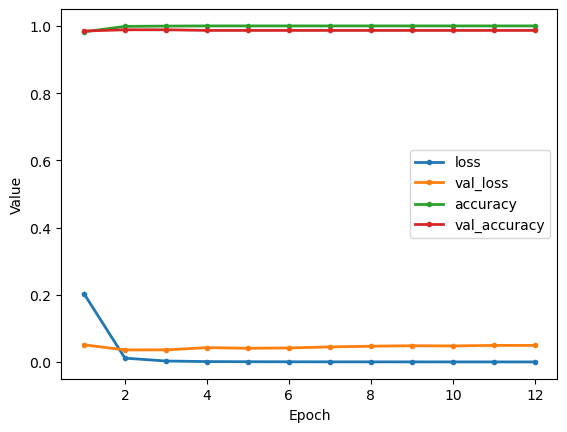

In [23]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [24]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k4, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/21 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

 8/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

15/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


 1/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

 7/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

13/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

19/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [25]:
report.save()

Report saved as Output/Reports/DBB/report_MI8VTH3N.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [26]:
"""k = 5
X, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()"""

"k = 5\nX, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)\nX_test.head()"

In [27]:
"""NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]"""

'NUM_CLASS  = 1\nSEQ_LENGTH = X_train.shape[1]'

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [28]:
"""name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'name="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n# Evaluate and sc

In [29]:
"""VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"""

"VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"

In [30]:
"""VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
report.save('end')"""

'VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) \nreport.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])\nreport.save(\'end\')'

In [31]:
# END

In [32]:
######################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################